https://github.com/mrdbourke/tensorflow-deep-learning

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd

tf.__version__

'2.5.0'

# EfficientNetB0

In [ ]:
%%capture

!wget -nc "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
!unzip -o "101_food_classes_10_percent"

In [38]:
datagen = ImageDataGenerator()

train_data_10_percent = datagen.flow_from_directory('101_food_classes_10_percent/train',
                                                    batch_size=32,
                                                    seed=123,
                                                    target_size=(224, 224),
                                                    class_mode='categorical')

test_data = datagen.flow_from_directory('101_food_classes_10_percent/test',
                                        batch_size=32,
                                        seed=123,
                                        target_size=(224, 224),
                                        class_mode='categorical')

Found 7575 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


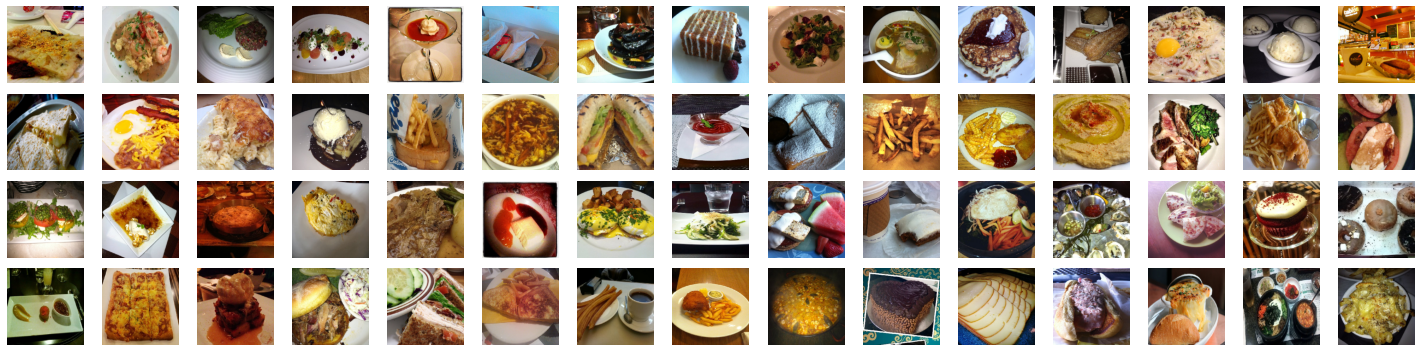

In [ ]:
# Get the images from a batch
imgs = train_data_10_percent.next()
labels = list(train_data_10_percent.class_indices.keys())

# Plot
plt.figure(figsize=(20, 5))
cols, rows = 15, 4
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[0][i])
    # plt.title(labels[np.argmax(imgs[1][i])])
    plt.axis('off')

plt.tight_layout();

In [35]:
data_augmentation = tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.)  # Needed for ResNet
])

In [39]:
# EfficientNet
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Model
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)
efficientnet = tf.keras.Model(inputs, outputs)

efficientnet.compile(loss='categorical_crossentropy',
                     optimizer='adam', 
                     metrics=['accuracy'])

h = efficientnet.fit(train_data_10_percent,
                     validation_data=test_data,
                     epochs=5,
                     validation_steps=int(0.15 * len(test_data)),
                     callbacks=[TqdmCallback(verbose=0)], verbose=0)

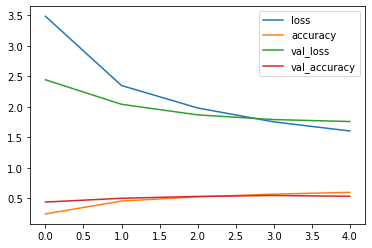

In [40]:
pd.DataFrame(h.history).plot();

In [61]:
x_test, y_test = [], []
for i in range(100):
    data = test_data.next()
    x_test.append(data[0])
    y_test.append(np.argmax(data[1], axis=1))
x_test = np.vstack(x_test)
y_test = np.hstack(y_test)
print(x_test.shape, y_test.shape)

(3200, 224, 224, 3) (3200,)


In [64]:
pred = np.argmax(efficientnet.predict(x_test), axis=1)
print(pred.shape, accuracy_score(y_test, pred))

(3200,) 0.5496875


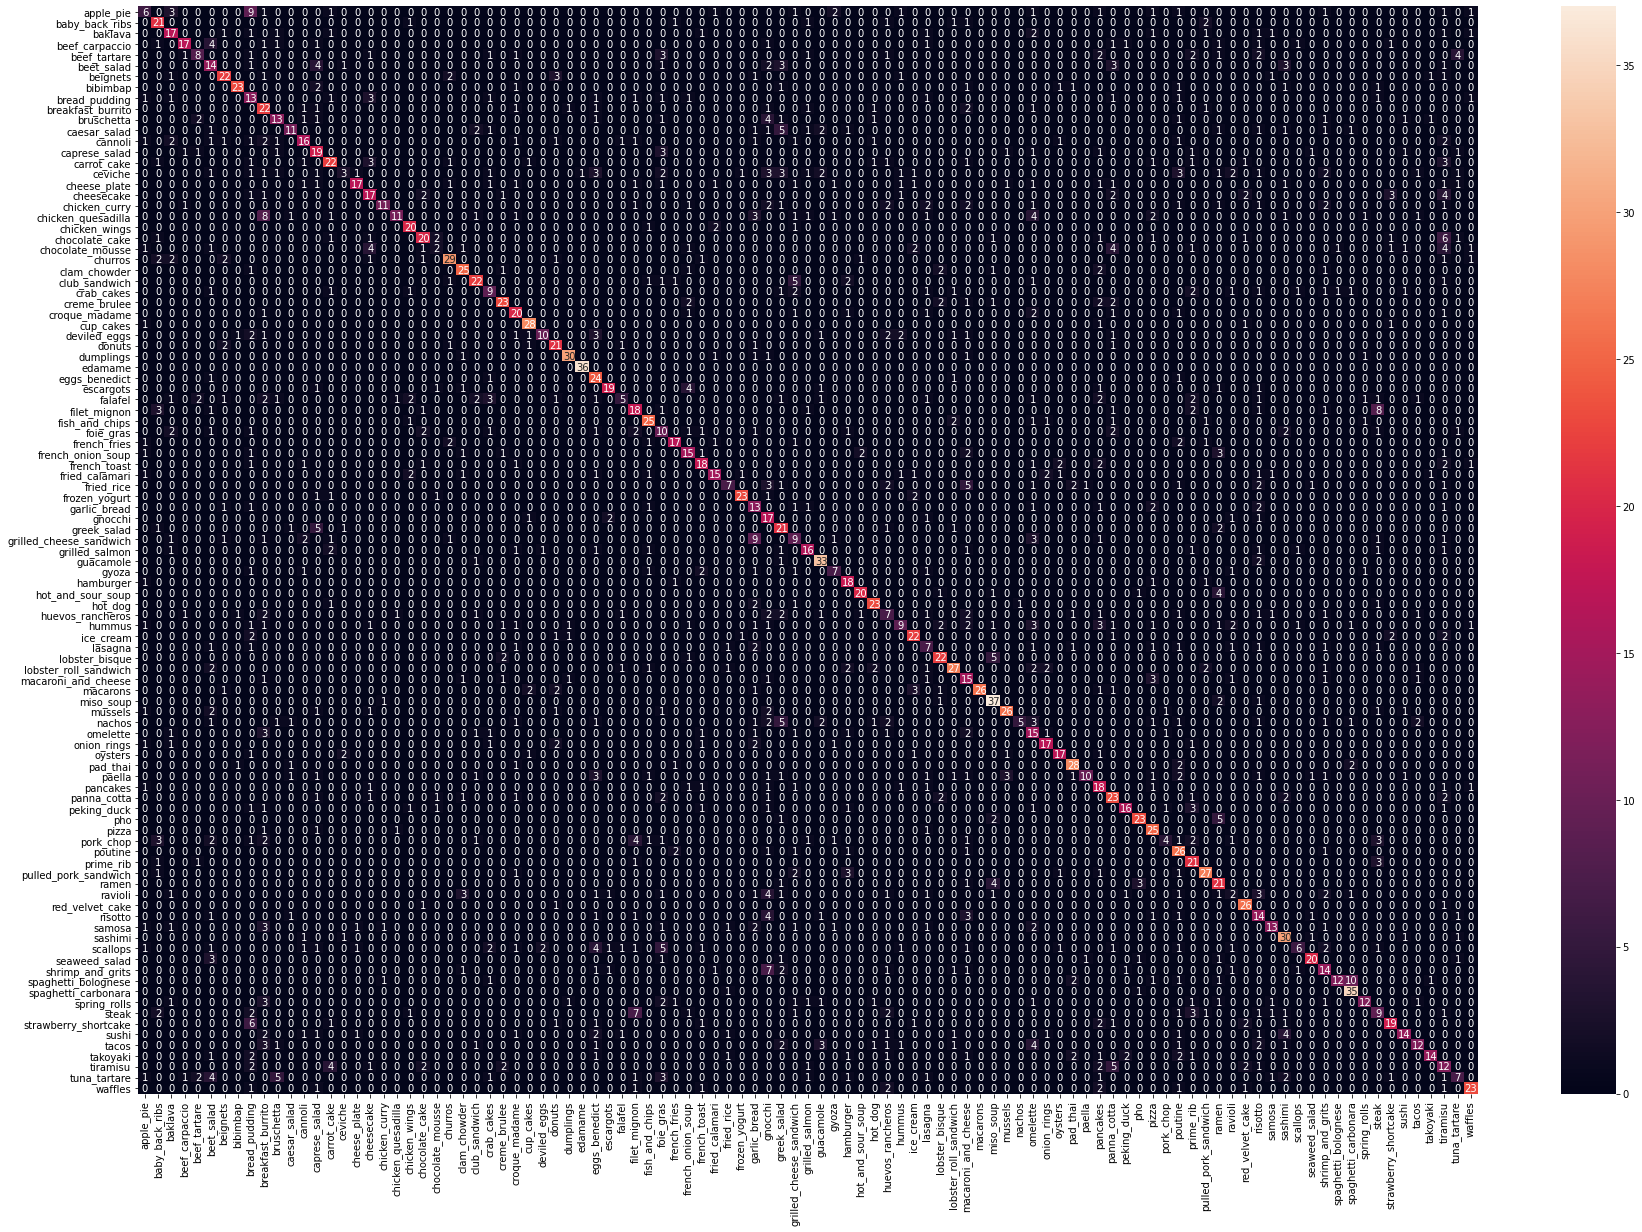

In [70]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion_matrix(y_test, pred),
            xticklabels=labels,
            yticklabels=labels,
            annot=True);